# Overview
This dataset offers a comprehensive snapshot of criminal activities within the city. It encompasses various aspects of each incident, including date, time, location, victim demographics, and more.

By leveraging machine learning techniques, participants can analyze this rich dataset to predict crime categories, enhance law enforcement strategies, and bolster public safety measures.

Your task is straightforward: Develop models capable of accurately predicting the crime categories based on this information.

Step up and demonstrate your prowess in anticipating crime categories – it's your chance to transform this data into actionable insights!

# Import Libraries

In [454]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix
from sklearn.svm import SVC



# A. Train dataset
## 1. Load Data

In [379]:
# Load data
crime_train = pd.read_csv('train.csv')
crime_train.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


## 2. Check for missing values

In [380]:
crime_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [381]:
crime_train.isnull().sum()

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

In [382]:
# Fill the missing values in the categorical columns with the mode
mode_imputer = SimpleImputer(strategy='most_frequent')
crime_train[['Modus_Operandi', 'Victim_Sex', 'Victim_Descent', 'Weapon_Description']] = mode_imputer.fit_transform(crime_train[['Modus_Operandi', 'Victim_Sex', 'Victim_Descent', 'Weapon_Description']])

In [383]:
# Delete the rows with missing values
crime_train.dropna(subset=['Premise_Description'], inplace=True)

In [384]:
skewness = crime_train['Weapon_Used_Code'].skew()
skewness

np.float64(-1.0329213954155365)

In [385]:
# Fill missing values with the median
median_imputer = SimpleImputer(strategy='median')
crime_train['Weapon_Used_Code'] = median_imputer.fit_transform(crime_train[['Weapon_Used_Code']])

In [386]:
# Drop the column with more than 80% missing values
crime_train.drop(columns=['Cross_Street'], inplace=True)

In [387]:
# Convert date from string to datetime format
crime_train['Date_Reported'] = crime_train['Date_Reported'].str.split(' ').str[0]
crime_train['Date_Occurred'] = crime_train['Date_Occurred'].str.split(' ').str[0]

crime_train['Day_Reported'] = pd.to_datetime(crime_train['Date_Reported'], format='%m/%d/%Y').dt.day
crime_train['Month_Reported'] = pd.to_datetime(crime_train['Date_Reported'], format='%m/%d/%Y').dt.month
crime_train['Year_Reported'] = pd.to_datetime(crime_train['Date_Reported'], format='%m/%d/%Y').dt.year

crime_train['Day_Occurred'] = pd.to_datetime(crime_train['Date_Occurred'], format='%m/%d/%Y').dt.day
crime_train['Month_Occurred'] = pd.to_datetime(crime_train['Date_Occurred'], format='%m/%d/%Y').dt.month
crime_train['Year_Occurred'] = pd.to_datetime(crime_train['Date_Occurred'], format='%m/%d/%Y').dt.year

# Drop the original column
crime_train.drop(['Date_Reported','Date_Occurred'], axis=1, inplace=True)

In [388]:
crime_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19995 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               19995 non-null  object 
 1   Latitude               19995 non-null  float64
 2   Longitude              19995 non-null  float64
 3   Time_Occurred          19995 non-null  float64
 4   Area_ID                19995 non-null  float64
 5   Area_Name              19995 non-null  object 
 6   Reporting_District_no  19995 non-null  float64
 7   Part 1-2               19995 non-null  float64
 8   Modus_Operandi         19995 non-null  object 
 9   Victim_Age             19995 non-null  float64
 10  Victim_Sex             19995 non-null  object 
 11  Victim_Descent         19995 non-null  object 
 12  Premise_Code           19995 non-null  float64
 13  Premise_Description    19995 non-null  object 
 14  Weapon_Used_Code       19995 non-null  float64
 15  Weapon_

# B.) Test dataset
## 1. Load data

In [389]:
crime_test = pd.read_csv('test.csv')
crime_test.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description
0,1500 LEIGHTON AV,NaN,34.0128,-118.3045,03/03/2020 12:00:00 AM,03/03/2020 12:00:00 AM,2000.0,3.0,Southwest,376.0,...,0416 1241 1243 1813 1821 2000,28.0,F,H,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont
1,100 S NORMANDIE AV,NaN,34.0726,-118.3029,06/01/2020 12:00:00 AM,04/25/2020 12:00:00 AM,1700.0,20.0,Olympic,2014.0,...,0344 0394,26.0,M,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont
2,300 E 111TH ST,NaN,33.9348,-118.2695,08/28/2020 12:00:00 AM,08/27/2020 12:00:00 AM,900.0,18.0,Southeast,1844.0,...,1822 0701 1914 0355 1202 0100,62.0,F,B,721.0,HIGH SCHOOL,NaN,NaN,IC,Invest Cont
3,1300 S LA BREA AV,NaN,34.0497,-118.3442,12/23/2020 12:00:00 AM,12/03/2020 12:00:00 AM,2200.0,7.0,Wilshire,765.0,...,NaN,0.0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont
4,11000 MORRISON ST,NaN,34.1611,-118.3704,08/30/2020 12:00:00 AM,08/29/2020 12:00:00 AM,130.0,15.0,N Hollywood,1555.0,...,1501,37.0,F,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AO,Adult Other


## 2. Check for missing values

In [390]:
crime_test.isnull().sum()

Location                    0
Cross_Street             4190
Latitude                    0
Longitude                   0
Date_Reported               0
Date_Occurred               0
Time_Occurred               0
Area_ID                     0
Area_Name                   0
Reporting_District_no       0
Part 1-2                    0
Modus_Operandi            684
Victim_Age                  0
Victim_Sex                643
Victim_Descent            643
Premise_Code                0
Premise_Description         1
Weapon_Used_Code         3153
Weapon_Description       3153
Status                      0
Status_Description          0
dtype: int64

In [391]:
# Drop column with more than 80% missing values
crime_test.drop(columns=['Cross_Street'], inplace=True)

In [392]:
# Fill the missing values in the categorical columns with the mode
mode_imputer = SimpleImputer(strategy='most_frequent')
crime_test[['Modus_Operandi', 'Victim_Sex', 'Victim_Descent', 'Weapon_Description']] = mode_imputer.fit_transform(crime_test[['Modus_Operandi', 'Victim_Sex', 'Victim_Descent', 'Weapon_Description']])

In [393]:
# Delete the rows with missing values
crime_test.dropna(subset=['Premise_Description'], inplace=True)

In [394]:
skewness = crime_test['Weapon_Used_Code'].skew()
skewness

np.float64(-1.0072144554507358)

In [395]:
# Fill missing values with the median
median_imputer = SimpleImputer(strategy='median')
crime_test['Weapon_Used_Code'] = median_imputer.fit_transform(crime_test[['Weapon_Used_Code']])

In [396]:
# Convert date from string to datetime format
crime_test['Date_Reported'] = crime_test['Date_Reported'].str.split(' ').str[0]
crime_test['Date_Occurred'] = crime_test['Date_Occurred'].str.split(' ').str[0]

crime_test['Day_Reported'] = pd.to_datetime(crime_test['Date_Reported'], format='%m/%d/%Y').dt.day
crime_test['Month_Reported'] = pd.to_datetime(crime_test['Date_Reported'], format='%m/%d/%Y').dt.month
crime_test['Year_Reported'] = pd.to_datetime(crime_test['Date_Reported'], format='%m/%d/%Y').dt.year

crime_test['Day_Occurred'] = pd.to_datetime(crime_test['Date_Occurred'], format='%m/%d/%Y').dt.day
crime_test['Month_Occurred'] = pd.to_datetime(crime_test['Date_Occurred'], format='%m/%d/%Y').dt.month
crime_test['Year_Occurred'] = pd.to_datetime(crime_test['Date_Occurred'], format='%m/%d/%Y').dt.year

# Drop the original column
crime_test.drop(['Date_Reported','Date_Occurred'], axis=1, inplace=True)

In [397]:
crime_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               4999 non-null   object 
 1   Latitude               4999 non-null   float64
 2   Longitude              4999 non-null   float64
 3   Time_Occurred          4999 non-null   float64
 4   Area_ID                4999 non-null   float64
 5   Area_Name              4999 non-null   object 
 6   Reporting_District_no  4999 non-null   float64
 7   Part 1-2               4999 non-null   float64
 8   Modus_Operandi         4999 non-null   object 
 9   Victim_Age             4999 non-null   float64
 10  Victim_Sex             4999 non-null   object 
 11  Victim_Descent         4999 non-null   object 
 12  Premise_Code           4999 non-null   float64
 13  Premise_Description    4999 non-null   object 
 14  Weapon_Used_Code       4999 non-null   float64
 15  Weapon_De

# 3. EDA

In [ ]:
crime_train.head()

## a.) Explore the relationship between the Victim sex and the victim descent.

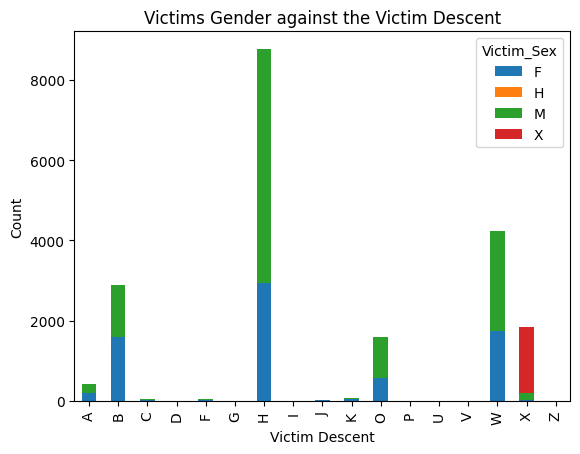

In [473]:
descent_ct = pd.crosstab(crime_train['Victim_Descent'], crime_train['Victim_Sex'])

descent_ct.plot(kind='bar', stacked=True)
plt.title('Victims Gender against the Victim Descent')
plt.xlabel('Victim Descent')
plt.ylabel('Count')
plt.show()

- Most of the victims across the different descent are male, closely followed by the female, X and the rest. 
- The victims from the decent H seem to be the most affected compared to the rest.

## b.) Explore the age distribution of the victims

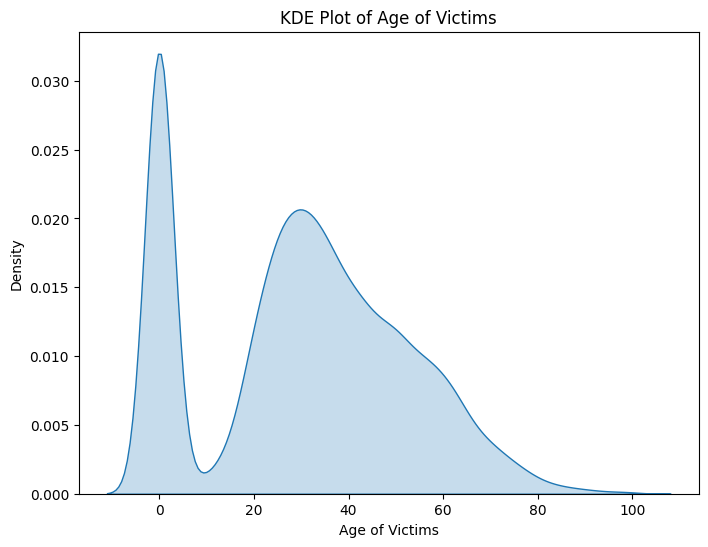

In [474]:
plt.figure(figsize=(8,6))
sns.kdeplot(data=crime_train, x=crime_train['Victim_Age'], fill=True)
plt.xlabel('Age of Victims')
plt.ylabel('Density')
plt.title('KDE Plot of Age of Victims')
plt.show()

## c.) What are the common places where crimes occur?

In [475]:
common_crime_areas = crime_train['Premise_Description'].value_counts().head(30)
common_crime_areas

Premise_Description
STREET                                          5033
SINGLE FAMILY DWELLING                          3379
MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)    2491
PARKING LOT                                     1437
SIDEWALK                                         978
OTHER BUSINESS                                   916
VEHICLE, PASSENGER/TRUCK                         679
GARAGE/CARPORT                                   437
DRIVEWAY                                         386
PARKING UNDERGROUND/BUILDING                     267
RESTAURANT/FAST FOOD                             228
DEPARTMENT STORE                                 176
MARKET                                           173
OTHER PREMISE                                    157
ALLEY                                            138
YARD (RESIDENTIAL/BUSINESS)                      138
GAS STATION                                      135
HOTEL                                            128
PARK/PLAYGROUND           

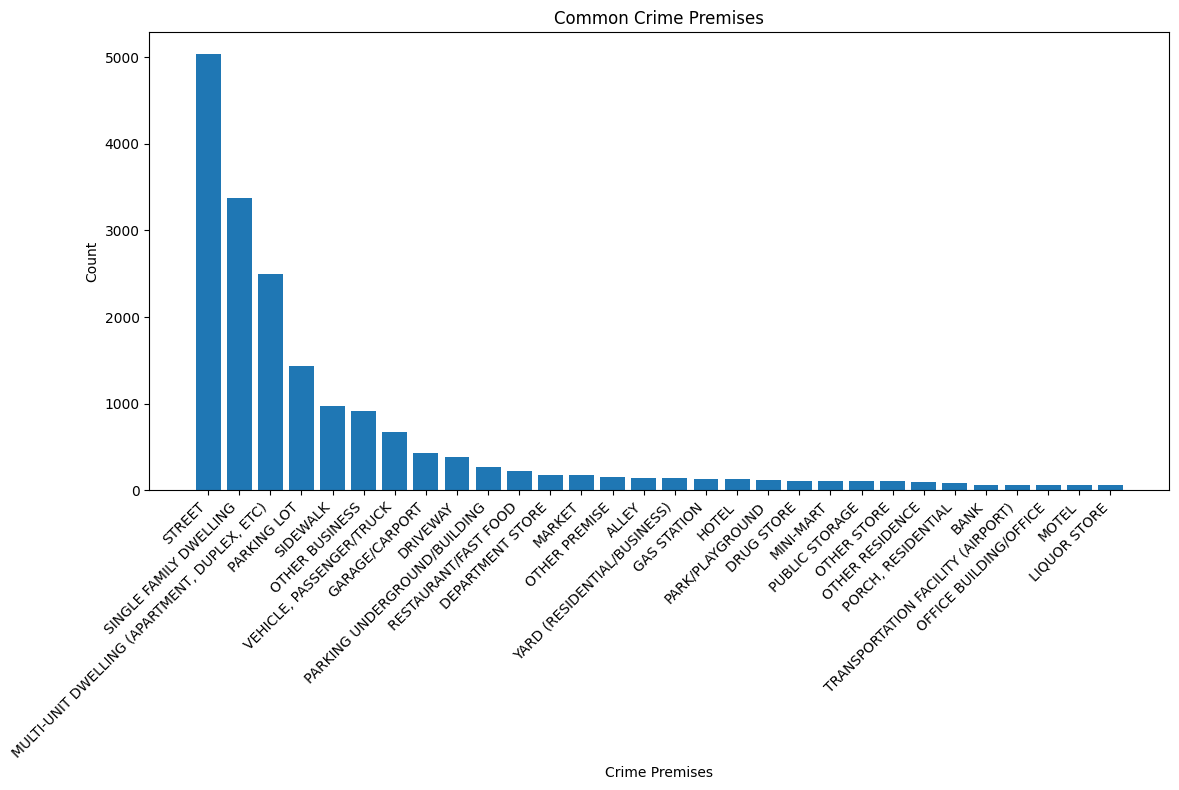

In [480]:
plt.figure(figsize=(12, 8)) 
plt.bar(common_crime_areas.index, common_crime_areas.values)
plt.xticks(rotation=45, ha='right') 
plt.title('Common Crime Premises')
plt.xlabel('Crime Premises')
plt.ylabel('Count')
plt.tight_layout() 
plt.show()

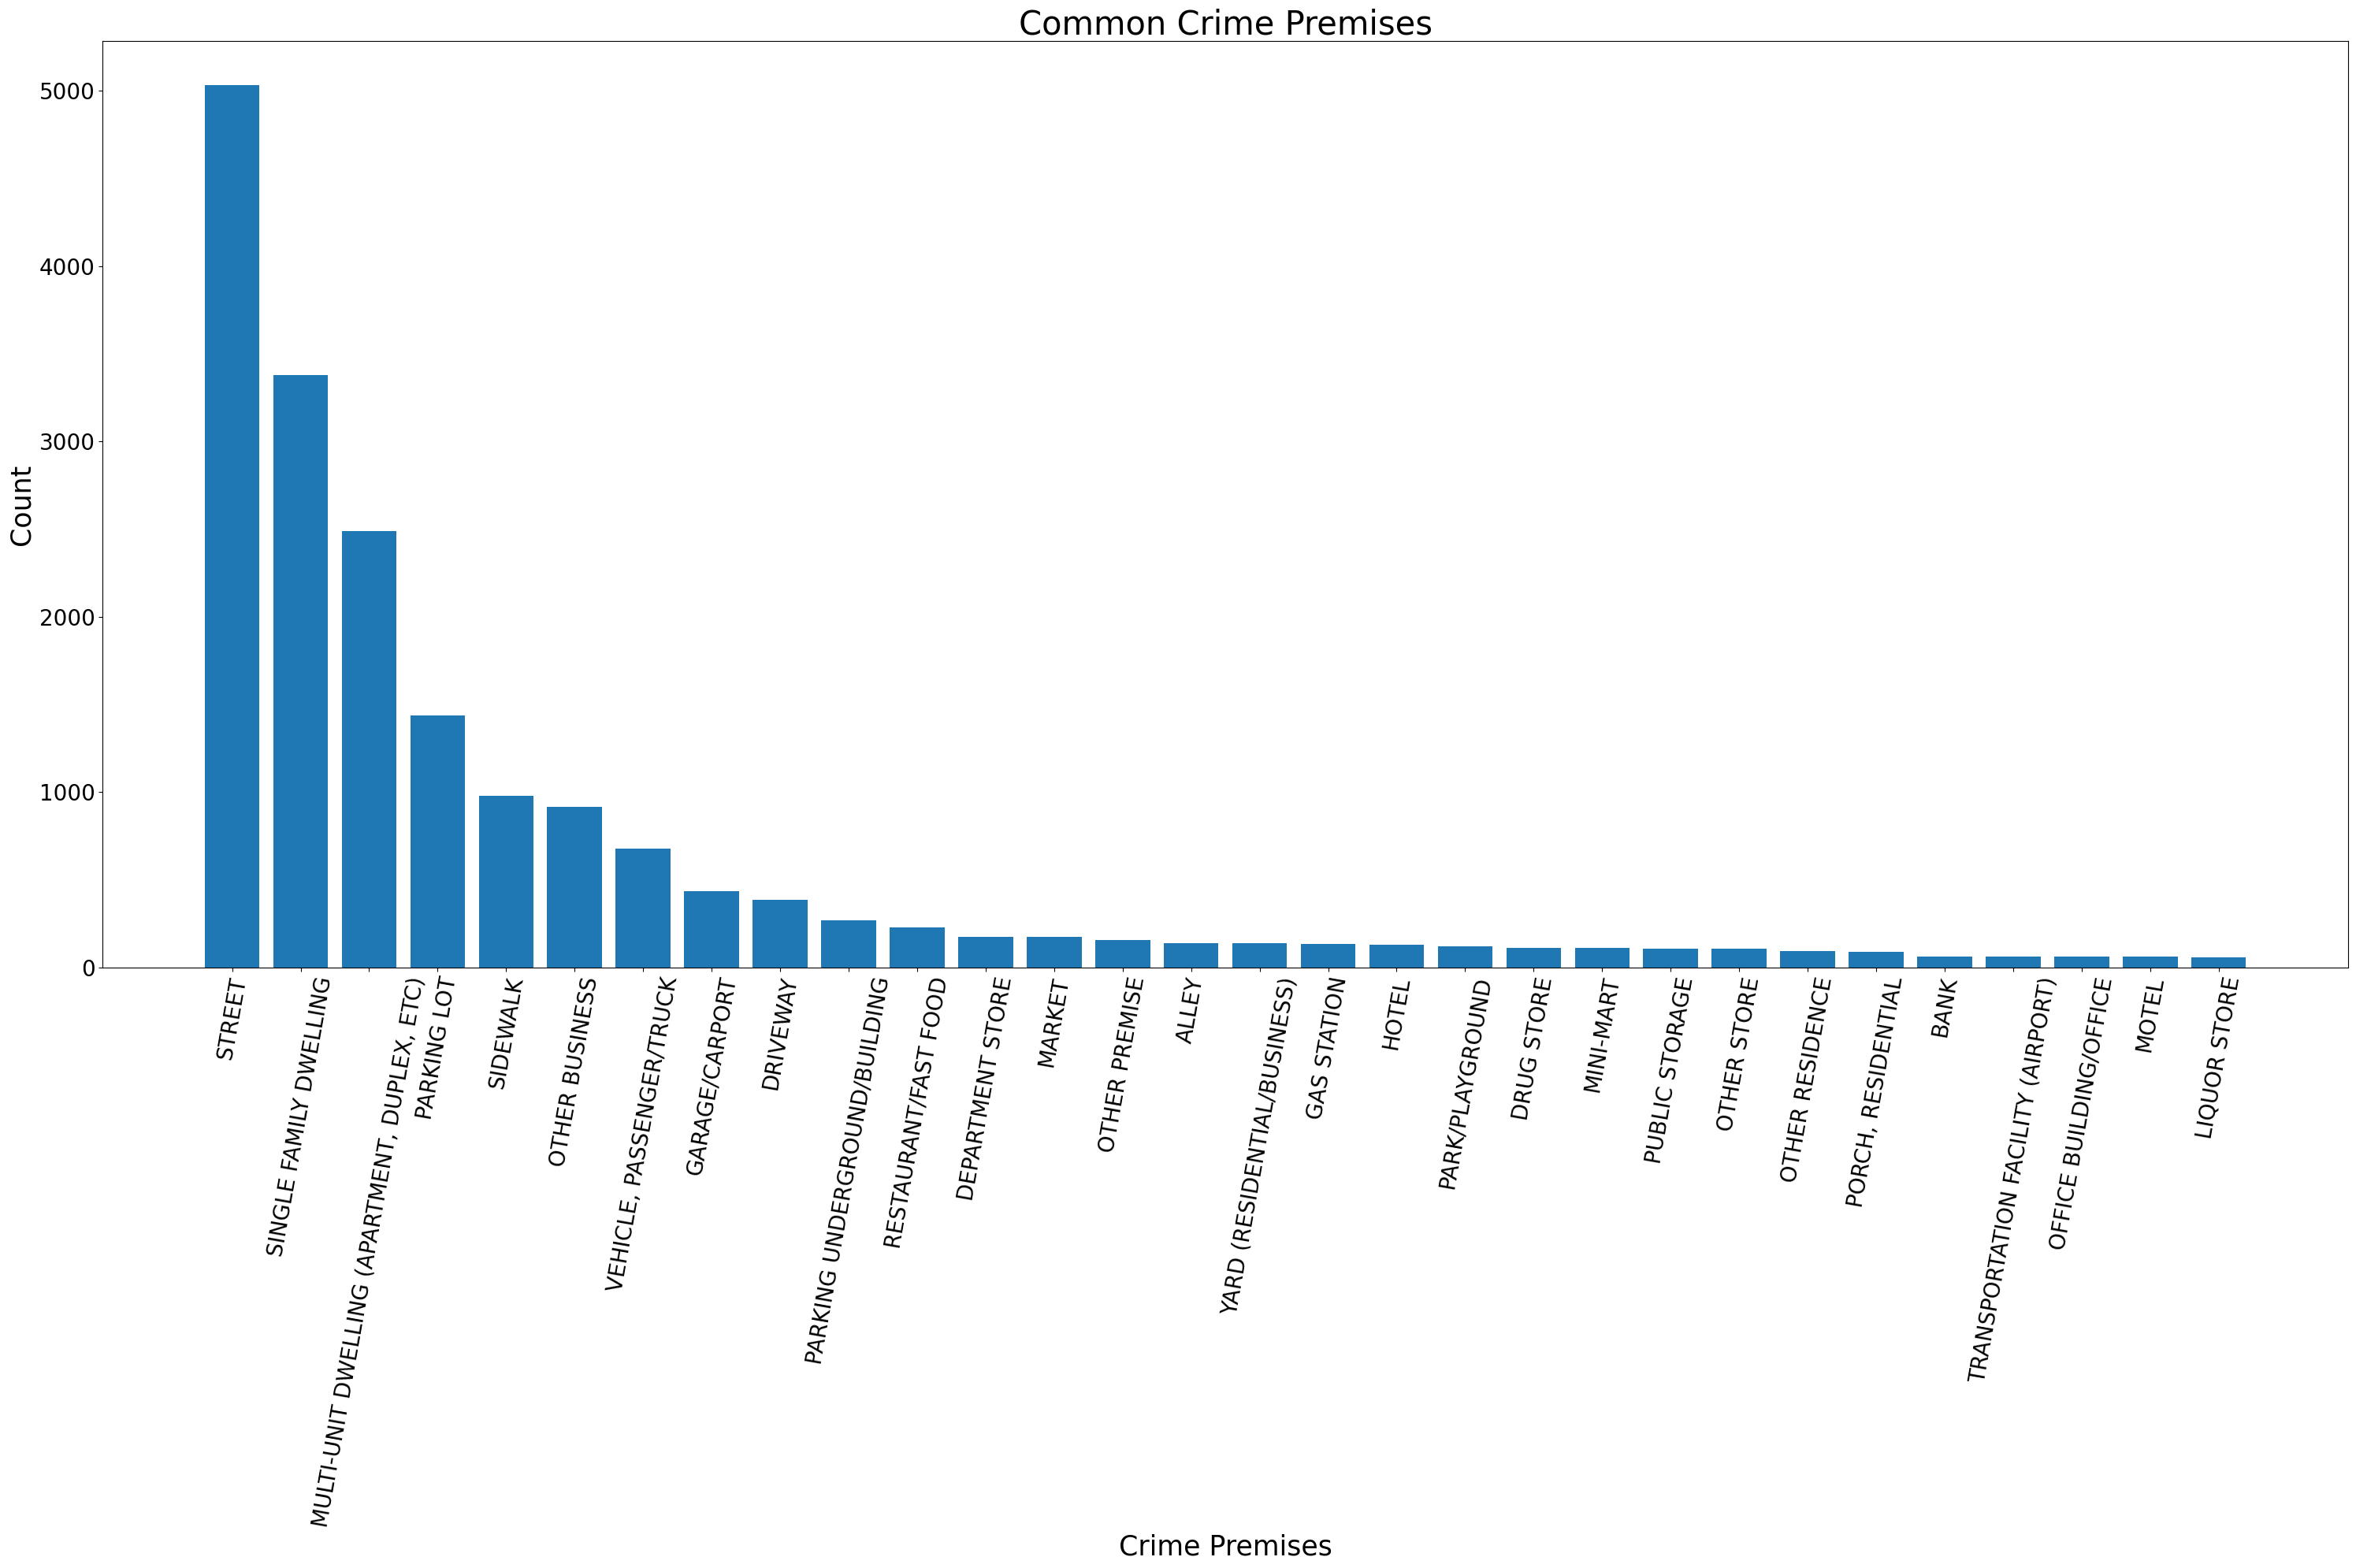

In [482]:
plt.figure(figsize=(30, 20))
plt.bar(common_crime_areas.index, common_crime_areas.values)

plt.title('Common Crime Premises', fontsize=30)
plt.xlabel('Crime Premises', fontsize=25)
plt.xticks(rotation=80, fontsize=20)
plt.ylabel('Count', fontsize=25)
plt.yticks(fontsize=20)
plt.tight_layout() 
plt.show()

## d.) Note any differences in the crimes experienced by the different gender.

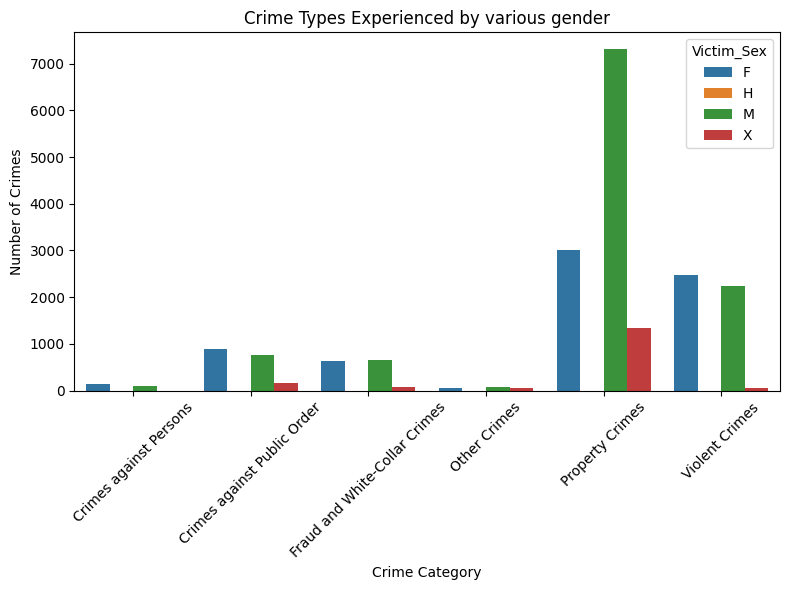

In [483]:
crime_by_sex = crime_train.groupby(['Victim_Sex', 'Crime_Category']).size().reset_index(name='Count')
crime_train
plt.figure(figsize=(8, 6))
sns.barplot(data=crime_by_sex, x='Crime_Category', y='Count', hue='Victim_Sex')
plt.title('Crime Types Experienced by various gender')
plt.xlabel('Crime Category')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## e.) Is there a trend in the crimes done with the weapons used

In [484]:
# Group the data by Crime_Category and Weapon_Description to see the distribution
crime_weapon_data = crime_train.groupby(['Crime_Category', 'Weapon_Description']).size().reset_index(name='Count')

# Create a pivot table for better visualization
crime_weapon_pivot = crime_weapon_data.pivot('Crime_Category', 'Weapon_Description', 'Count').fillna(0)

# Plotting the relationship using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(crime_weapon_pivot, cmap='Blues', annot=True, fmt='g')
plt.title('Relationship Between Crime Category and Weapon Used')
plt.xlabel('Weapon Description')
plt.ylabel('Crime Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

## f.) What is the frequency of crimes over time (daily, monthly, yearly)?

In [486]:
# Assuming your data has 'Year' and 'Month' columns already extracted

# Group by 'Year' and 'Month' and count occurrences
monthly_crime_count = crime_train.groupby(['Year_Occurred', 'Month_Occurred']).size()

# Reset the index if you want a flat DataFrame
monthly_crime_count = monthly_crime_count.reset_index(name='Crime_Count')

# Sort by year and month for better readability (optional)
monthly_crime_count = monthly_crime_count.sort_values(['Year_Occurred', 'Month_Occurred'])

# Display the result
print(monthly_crime_count)


    Year_Occurred  Month_Occurred  Crime_Count
0            2020               1         1835
1            2020               2         1663
2            2020               3         1630
3            2020               4         1568
4            2020               5         1754
5            2020               6         1696
6            2020               7         1670
7            2020               8         1662
8            2020               9         1642
9            2020              10         1685
10           2020              11         1552
11           2020              12         1638


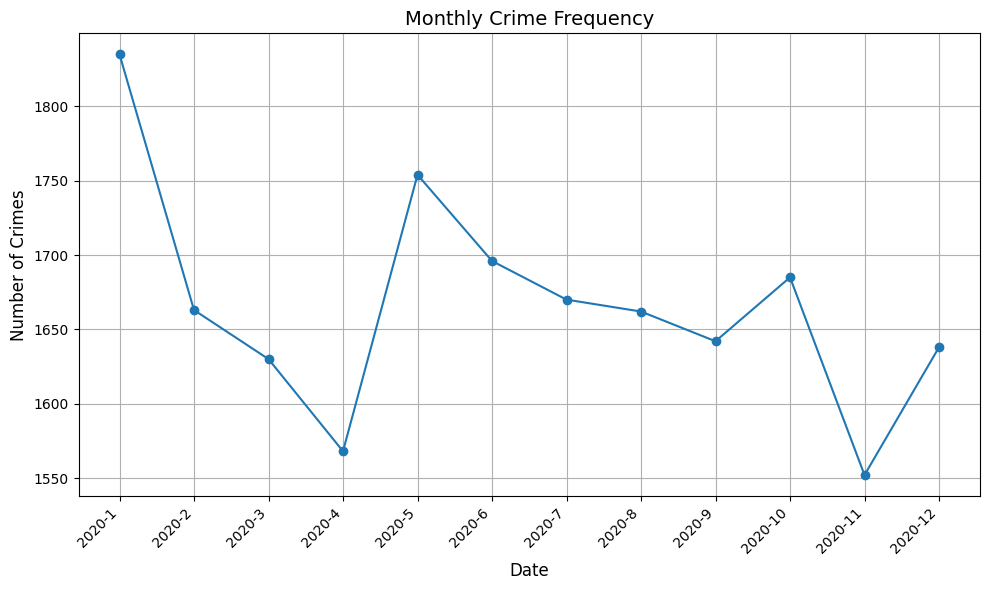

In [488]:
# Plot the monthly crime counts
plt.figure(figsize=(10, 6))
plt.plot(monthly_crime_count['Year_Occurred'].astype(str) + '-' + monthly_crime_count['Month_Occurred'].astype(str), 
         monthly_crime_count['Crime_Count'], marker='o')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.title('Monthly Crime Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


## g.) Which areas (based on Area_ID or Area_Name) report the highest number of crimes? How does crime distribution vary by geographic region?

In [489]:
# Group by 'Area_ID' or 'Area_Name' and count occurrences
area_crime_count = crime_train.groupby('Area_Name').size()

# Reset the index to get a DataFrame
area_crime_count = area_crime_count.reset_index(name='Crime_Count')

# Sort the DataFrame by 'Crime_Count' in descending order
area_crime_count_sorted = area_crime_count.sort_values(by='Crime_Count', ascending=False)

# Display the top areas with the highest crime counts
top_areas = area_crime_count_sorted.head(10)
print(top_areas)


      Area_Name  Crime_Count
0   77th Street         1344
1       Central         1156
12      Pacific         1156
15    Southwest         1130
14    Southeast         1067
8   N Hollywood         1065
6     Hollywood         1013
9        Newton          999
11      Olympic          960
20     Wilshire          941


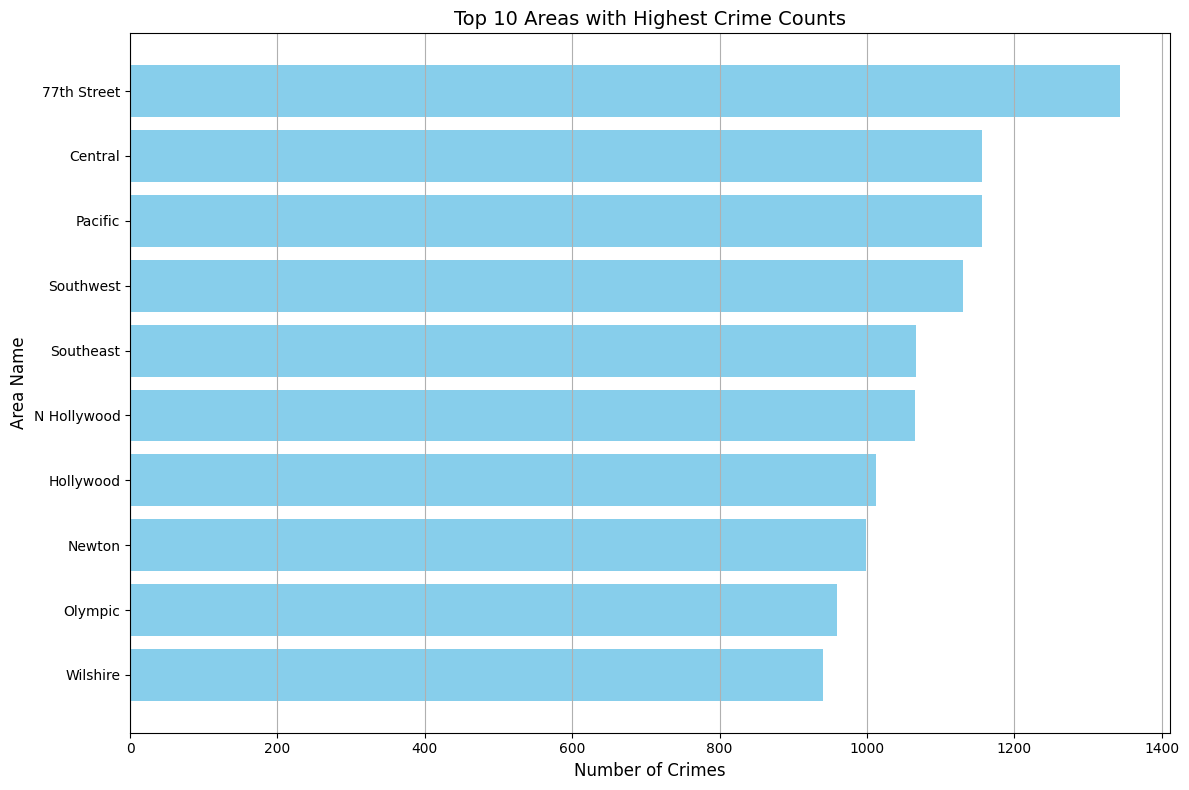

In [490]:
# Plot the top areas
plt.figure(figsize=(12, 8))
plt.barh(top_areas['Area_Name'], top_areas['Crime_Count'], color='skyblue')
plt.xlabel('Number of Crimes', fontsize=12)
plt.ylabel('Area Name', fontsize=12)
plt.title('Top 10 Areas with Highest Crime Counts', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()


## h.) What is the age distribution of victims? Is there any correlation between age and the type of crime?

## i.) What proportion of crimes are marked as "Investigation Continued" (IC), and how does this compare across different areas or crime categories?
Are there differences in status descriptions across different geographic areas or types of crimes?

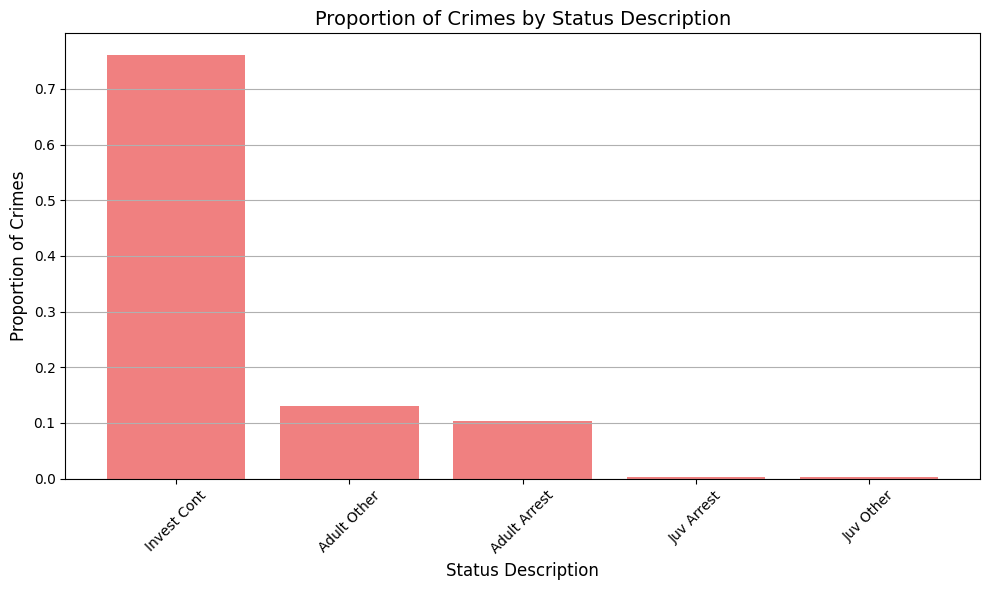

In [491]:
# Step 1: Count occurrences of each Status_Description
status_counts = crime_train['Status_Description'].value_counts()

# Step 2: Calculate the proportion
status_proportions = status_counts / status_counts.sum()

# Step 3: Create a DataFrame for easier plotting
status_df = status_proportions.reset_index()
status_df.columns = ['Status_Description', 'Proportion']


plt.figure(figsize=(10, 6))
plt.bar(status_df['Status_Description'], status_df['Proportion'], color='lightcoral')
plt.xlabel('Status Description', fontsize=12)
plt.ylabel('Proportion of Crimes', fontsize=12)
plt.title('Proportion of Crimes by Status Description', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## j.) Are certain crimes more prevalent in specific areas? For example, are certain types of property crimes concentrated in certain districts?


In [ ]:

# Create age groups
bins = [0, 18, 30, 50, 100]
labels = ['0-18', '19-30', '31-50', '50+']
crime_train['Age_Group'] = pd.cut(crime_train['Victim_Age'], bins=bins, labels=labels, right=False)

# Group by Victim_Sex, Crime_Category, and Age_Group
crime_by_sex_age = crime_train.groupby(['Victim_Sex', 'Crime_Category', 'Age_Group']).size().reset_index(name='Count')

# Plotting the data using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=crime_by_sex_age, x='Crime_Category', y='Count', hue='Victim_Sex', dodge=True)
plt.title('Crime Types Experienced by Gender and Age Group')
plt.xlabel('Crime Category')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Encoding
## A. Train data Encoding

In [398]:
crime_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19995 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               19995 non-null  object 
 1   Latitude               19995 non-null  float64
 2   Longitude              19995 non-null  float64
 3   Time_Occurred          19995 non-null  float64
 4   Area_ID                19995 non-null  float64
 5   Area_Name              19995 non-null  object 
 6   Reporting_District_no  19995 non-null  float64
 7   Part 1-2               19995 non-null  float64
 8   Modus_Operandi         19995 non-null  object 
 9   Victim_Age             19995 non-null  float64
 10  Victim_Sex             19995 non-null  object 
 11  Victim_Descent         19995 non-null  object 
 12  Premise_Code           19995 non-null  float64
 13  Premise_Description    19995 non-null  object 
 14  Weapon_Used_Code       19995 non-null  float64
 15  Weapon_

In [399]:
# Create a copy of the dataset
crime_train_encoded = crime_train.copy()

In [400]:
crime_train_encoded.isnull().sum()

Location                 0
Latitude                 0
Longitude                0
Time_Occurred            0
Area_ID                  0
Area_Name                0
Reporting_District_no    0
Part 1-2                 0
Modus_Operandi           0
Victim_Age               0
Victim_Sex               0
Victim_Descent           0
Premise_Code             0
Premise_Description      0
Weapon_Used_Code         0
Weapon_Description       0
Status                   0
Status_Description       0
Crime_Category           0
Day_Reported             0
Month_Reported           0
Year_Reported            0
Day_Occurred             0
Month_Occurred           0
Year_Occurred            0
dtype: int64

In [401]:
# Encoding of the Target variable
Le = LabelEncoder()
crime_train_encoded['Crime_Category'] = Le.fit_transform(crime_train_encoded['Crime_Category'])

In [402]:
# Encoding selected categorical columns using one-hot encoding
oh_encoder = OneHotEncoder(sparse_output=False, drop=None, handle_unknown='ignore')

encoded_cols = oh_encoder.fit_transform(crime_train_encoded[['Status', 'Victim_Sex', 'Victim_Descent']])
encoded_df = pd.DataFrame(encoded_cols, columns=oh_encoder.get_feature_names_out(['Status', 'Victim_Sex', 'Victim_Descent']))
encoded_df.index = crime_train_encoded.index
crime_train_encoded = pd.concat([crime_train_encoded.drop(['Status', 'Victim_Sex', 'Victim_Descent'], axis=1), encoded_df], axis=1)

In [412]:
crime_train_encoded.drop(columns=['Location', 'Area_Name', 'Modus_Operandi', 'Premise_Description', 'Weapon_Description',
                               'Status_Description'], inplace=True)

In [403]:
crime_train_encoded.head(2)

,Location,Latitude,Longitude,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,...,Victim_Descent_I,Victim_Descent_J,Victim_Descent_K,Victim_Descent_O,Victim_Descent_P,Victim_Descent_U,Victim_Descent_V,Victim_Descent_W,Victim_Descent_X,Victim_Descent_Z
0,4500 CARPENTER AV,34.1522,-118.3910,1800.0,15.0,N Hollywood,1563.0,1.0,0385,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,45TH ST,34.0028,-118.2391,1345.0,13.0,Newton,1367.0,1.0,0906 0352 0371 0446 1822 0344 0416 0417,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [404]:
crime_train_encoded.isnull().sum()

Location                 0
Latitude                 0
Longitude                0
Time_Occurred            0
Area_ID                  0
Area_Name                0
Reporting_District_no    0
Part 1-2                 0
Modus_Operandi           0
Victim_Age               0
Premise_Code             0
Premise_Description      0
Weapon_Used_Code         0
Weapon_Description       0
Status_Description       0
Crime_Category           0
Day_Reported             0
Month_Reported           0
Year_Reported            0
Day_Occurred             0
Month_Occurred           0
Year_Occurred            0
Status_AA                0
Status_AO                0
Status_IC                0
Status_JA                0
Status_JO                0
Victim_Sex_F             0
Victim_Sex_H             0
Victim_Sex_M             0
Victim_Sex_X             0
Victim_Descent_A         0
Victim_Descent_B         0
Victim_Descent_C         0
Victim_Descent_D         0
Victim_Descent_F         0
Victim_Descent_G         0
V

In [293]:
#crime_train_encoded.dropna(subset=['Crime_Category'], inplace=True)

## B. Test data Encoding

In [405]:
crime_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               4999 non-null   object 
 1   Latitude               4999 non-null   float64
 2   Longitude              4999 non-null   float64
 3   Time_Occurred          4999 non-null   float64
 4   Area_ID                4999 non-null   float64
 5   Area_Name              4999 non-null   object 
 6   Reporting_District_no  4999 non-null   float64
 7   Part 1-2               4999 non-null   float64
 8   Modus_Operandi         4999 non-null   object 
 9   Victim_Age             4999 non-null   float64
 10  Victim_Sex             4999 non-null   object 
 11  Victim_Descent         4999 non-null   object 
 12  Premise_Code           4999 non-null   float64
 13  Premise_Description    4999 non-null   object 
 14  Weapon_Used_Code       4999 non-null   float64
 15  Weapon_De

In [406]:
# Create a copy of the dataset
crime_test_encoded = crime_test.copy()

In [407]:
# Encoding selected categorical columns using one-hot encoding
#oh_encoder = OneHotEncoder(sparse_output=False,drop=None, handle_unknown='ignore')

# Now apply the same encoder to the test set using transform (without refitting)
encoded_cols = oh_encoder.transform(crime_test_encoded[['Status', 'Victim_Sex', 'Victim_Descent']])
encoded_df = pd.DataFrame(encoded_cols, columns=oh_encoder.get_feature_names_out(['Status', 'Victim_Sex', 'Victim_Descent']))
encoded_df.index = crime_test_encoded.index 
crime_test_encoded = pd.concat([crime_test_encoded.drop(['Status', 'Victim_Sex', 'Victim_Descent'], axis=1), encoded_df], axis=1)

In [408]:
crime_test_encoded.drop(columns=['Location', 'Area_Name', 'Modus_Operandi', 'Premise_Description', 'Weapon_Description',
                               'Status_Description'], inplace=True)

In [409]:
crime_test_encoded.isnull().sum()

Latitude                 0
Longitude                0
Time_Occurred            0
Area_ID                  0
Reporting_District_no    0
Part 1-2                 0
Victim_Age               0
Premise_Code             0
Weapon_Used_Code         0
Day_Reported             0
Month_Reported           0
Year_Reported            0
Day_Occurred             0
Month_Occurred           0
Year_Occurred            0
Status_AA                0
Status_AO                0
Status_IC                0
Status_JA                0
Status_JO                0
Victim_Sex_F             0
Victim_Sex_H             0
Victim_Sex_M             0
Victim_Sex_X             0
Victim_Descent_A         0
Victim_Descent_B         0
Victim_Descent_C         0
Victim_Descent_D         0
Victim_Descent_F         0
Victim_Descent_G         0
Victim_Descent_H         0
Victim_Descent_I         0
Victim_Descent_J         0
Victim_Descent_K         0
Victim_Descent_O         0
Victim_Descent_P         0
Victim_Descent_U         0
V

# 5. Modelling

In [413]:
# Define features and target variable
X_train = crime_train_encoded.drop('Crime_Category', axis=1)
y_train = crime_train_encoded['Crime_Category']
X_test = crime_test_encoded

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [449]:
# Initialize and train the model
rf_model = RandomForestClassifier( n_estimators=100 ,random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [450]:
# Predict on validation set
y_pred = rf_model.predict(X_val)

In [451]:
# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'classification_report: {classification_rep}')

Accuracy: 0.78
classification_report:               precision    recall  f1-score   support

           0       0.82      0.36      0.50        39
           1       0.78      0.33      0.46       382
           2       0.58      0.61      0.59       249
           3       1.00      0.03      0.05        36
           4       0.88      0.90      0.89      2284
           5       0.64      0.77      0.70      1009

    accuracy                           0.78      3999
   macro avg       0.78      0.50      0.53      3999
weighted avg       0.79      0.78      0.77      3999



In [417]:
# Predict on test set
y_test_pred = rf_model.predict(X_test)

In [461]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [462]:
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [463]:
y_lr_pred = lr_model.predict(X_val_scaled)

In [444]:
accuracy = accuracy_score(y_val, y_lr_pred)
print(f'Accuracy: {accuracy:.2f}')

# Confusion matrix
confusion = confusion_matrix(y_val, y_lr_pred)
print("Confusion Matrix:")
print(confusion)

# Classification report
report = classification_report(y_val, y_lr_pred)
print("Classification Report:")
print(report)

Accuracy: 0.70
Confusion Matrix:
[[   3    0    3    0    4   29]
 [   2    9   37    0   99  235]
 [   2    0  133    0   49   65]
 [   0    1    4    0   15   16]
 [   1    3   41    0 2049  190]
 [   3    4   41    0  363  598]]
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.08      0.12        39
           1       0.53      0.02      0.05       382
           2       0.51      0.53      0.52       249
           3       0.00      0.00      0.00        36
           4       0.79      0.90      0.84      2284
           5       0.53      0.59      0.56      1009

    accuracy                           0.70      3999
   macro avg       0.44      0.35      0.35      3999
weighted avg       0.67      0.70      0.66      3999



c:\Users\Esther\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Esther\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Esther\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [464]:
y_lrtest_pred = lr_model.predict(X_test_scaled)

In [465]:
# Create the SVM model
svm_model = SVC(kernel='linear')

# Fit the model on the scaled training data
svm_model.fit(X_train_scaled, y_train)

SVC(kernel='linear')

In [468]:
# Make predictions on the scaled test set
y_pred_svc = svm_model.predict(X_val_scaled)

In [469]:
accuracy = accuracy_score(y_val, y_pred_svc)
print(f'Accuracy: {accuracy:.2f}')

# Confusion matrix
confusion = confusion_matrix(y_val, y_pred_svc)
print("Confusion Matrix:")
print(confusion)

# Classification report
report = classification_report(y_val, y_pred_svc)
print("Classification Report:")
print(report)

Accuracy: 0.71
Confusion Matrix:
[[   1    0    4    0    0   34]
 [   1    9   46    0   26  300]
 [   0    0  139    0   14   96]
 [   0    2    4    0    5   25]
 [   1    4   59    0 1920  300]
 [   0    6   47    0  196  760]]
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.03      0.05        39
           1       0.43      0.02      0.04       382
           2       0.46      0.56      0.51       249
           3       0.00      0.00      0.00        36
           4       0.89      0.84      0.86      2284
           5       0.50      0.75      0.60      1009

    accuracy                           0.71      3999
   macro avg       0.44      0.37      0.34      3999
weighted avg       0.71      0.71      0.68      3999



c:\Users\Esther\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Esther\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Esther\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [470]:
# Initialize and fit the Gradient Boosting model
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_model.fit(X_train_scaled, y_train)

GradientBoostingClassifier(random_state=42)

In [471]:
# Make predictions on the test set
y_gbm_pred = gbm_model.predict(X_test_scaled)

In [472]:
# Evaluate the model
# accuracy = accuracy_score(y_val, y_gbm_pred)
# print(f'Gradient Boosting Accuracy: {accuracy:.2f}')

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_gbm_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_gbm_pred))

Classification Report:


ValueError: Found input variables with inconsistent numbers of samples: [3999, 4999]